In [1]:
import glob
import math
import time
import operator
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryFile
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

In [2]:
def normalize_gray_to_rgb(img):
    img *= 255.0 / img.max()
    img = np.expand_dims(img, 2)
    img = np.array(cv2.merge((img, img, img)), np.uint8)
    
    return img

def load_images(files, num=0):
    imgs = None
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        
        if imgs is None:
            imgs = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
            
        imgs = np.append(imgs, img[None,:], axis=0)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6, width=300):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > width:
        width_img = int(math.ceil(float(width) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

In [166]:
def to_colorspace(img, space='LUV'):
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img

def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 
                        
def color_hist(img, nbins=32):
    channels = []
    
    for idx in range(img.shape[-1]):
        ch = np.histogram(img[:,:,idx], bins=nbins, range=(0, 255))
        channels.append(ch[0])

    return np.hstack(tuple(channels))

def hog_features(img, space='LUV', orient=8, ppc=8, cpb=2, vis=False, vec=False):
    features = []
    previews = []
    img = to_colorspace(img, space)
    
    for idx in range(img.shape[-1]):
        hog_features = hog(
            img[:,:,idx], 
            orientations=orient, 
            pixels_per_cell=(ppc, ppc), 
            cells_per_block=(cpb, cpb), 
            transform_sqrt=True, 
            visualise=vis, 
            feature_vector=vec
        )

        if vis:
            _, preview = hog_features
            preview = normalize_gray_to_rgb(preview)
            previews.append(preview)
        else:
            features.append(hog_features)
    
    if vis:
        return np.array(previews).astype(np.uint8)
    else:
        return np.array(np.ravel(features)).astype(np.float64)

def add_heat(heatmap, bboxs, threshold):
    for bbox in bboxs:
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1

    heatmap[heatmap <= threshold] = 0
    return np.clip(heatmap, 0, 255)

def draw_boxes(img, bboxes):
    img = np.copy(img)
    val = np.random.randint(150, 256)
    idx = np.random.randint(0, 3)
    
    for bbox in bboxes:
        color_list = [0, 0, 0]
        color_list[idx] = val
        color = tuple(color_list)
        cv2.rectangle(img, bbox[0], bbox[1], color, 2)

    return img

def find_features(img):
    hog_feature = hog_features(img, vec=True)
    spatial_feature = bin_spatial(img, size=(16, 16))
    hist_feature = color_hist(img, nbins=32)
    file_features = [hog_feature, spatial_feature, hist_feature]
    
    return np.concatenate(file_features)

def features_from_files(files):
    features = []

    for file in files:
        img = load_images([file])[0]
        file_features = find_features(img)
        features.append(file_features)

    return features

def hog_previews(files):
    previews = []
    
    for file in files:   
        img = load_images([file])[0]
        previews.append(img)
        
        preview_channels = hog_features(img, vis=True, vec=True)
        previews.extend(preview_channels)

    return previews

def slide_windows(img, margin_y, win_size, xy_overlap=[0.75, 0.75]):
    windows = []
    margin_x = (0, img.shape[1])

    xspan = margin_x[1] - margin_x[0]
    yspan = margin_y[1] - margin_y[0]
    
    # Compute the number of pixels per step in x/y
    px_in_step_x = np.int(win_size * (1 - xy_overlap[0]))
    px_in_step_y = np.int(win_size * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    buffer_x = np.int(win_size * xy_overlap[0])
    buffer_y = np.int(win_size * xy_overlap[1])
    num_win_x = np.int((xspan - buffer_x) / px_in_step_x) 
    num_win_y = np.int((yspan - buffer_y) / px_in_step_y) 

    for ys in range(num_win_y):
        for xs in range(num_win_x):
            startx = xs * px_in_step_x + margin_x[0]
            endx = startx + win_size
            
            starty = ys * px_in_step_y + margin_y[0]
            endy = starty + win_size
            
            windows.append(((startx, starty), (endx, endy)))

    return windows

def search_windows(img, windows, clf, scaler):
    result = []

    for idx, window in enumerate(windows):
        cropped_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))    

        features = find_features(cropped_img)
        features = np.array(features).reshape(1, -1)
        features = scaler.transform(features)

        if clf.predict(features):
            result.append(window)

    return result

In [4]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

Cars in dataset: 8792; Non-cars in dataset: 8968


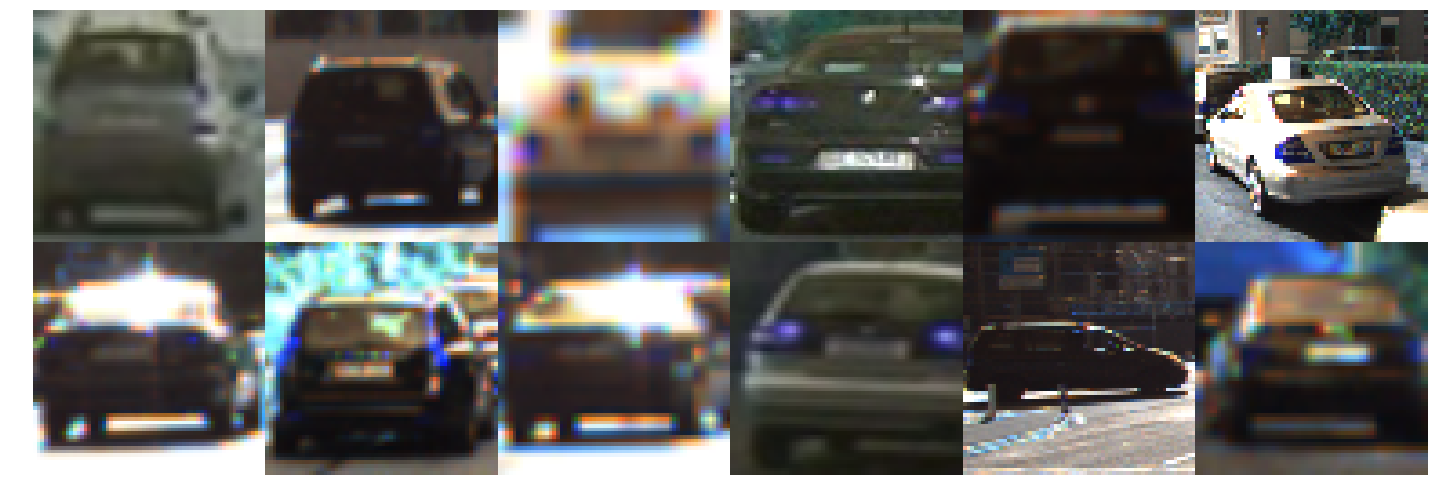

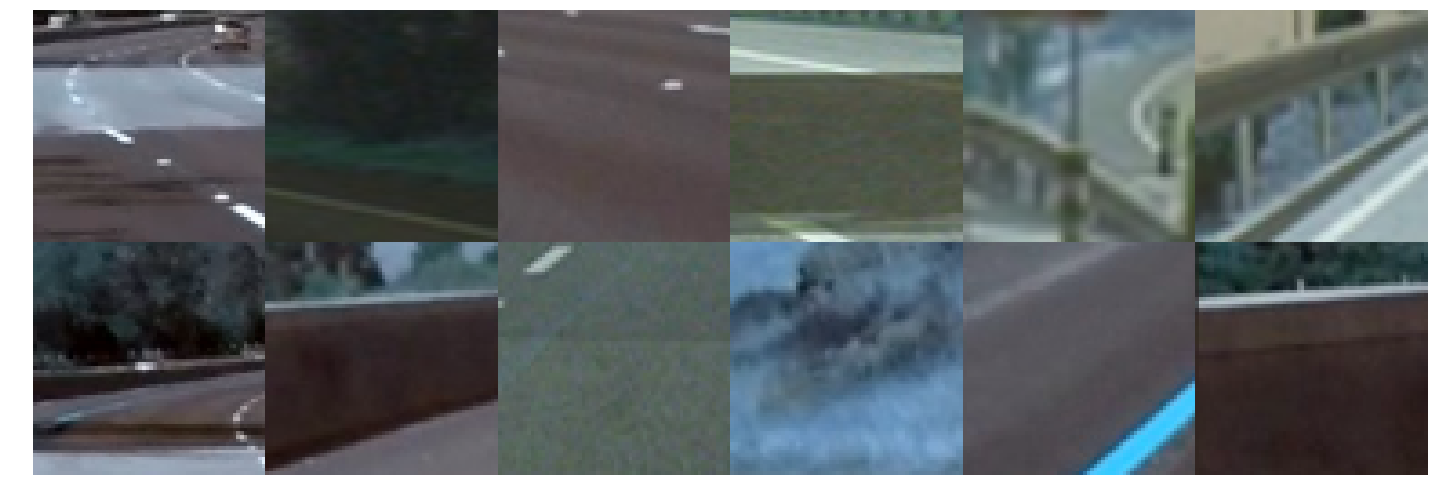

In [5]:
preview_cars = load_images(files_cars, num=12)
display_image_set(preview_cars, "cars")

preview_noncars = load_images(files_noncars, num=12)
display_image_set(preview_noncars, "noncars")

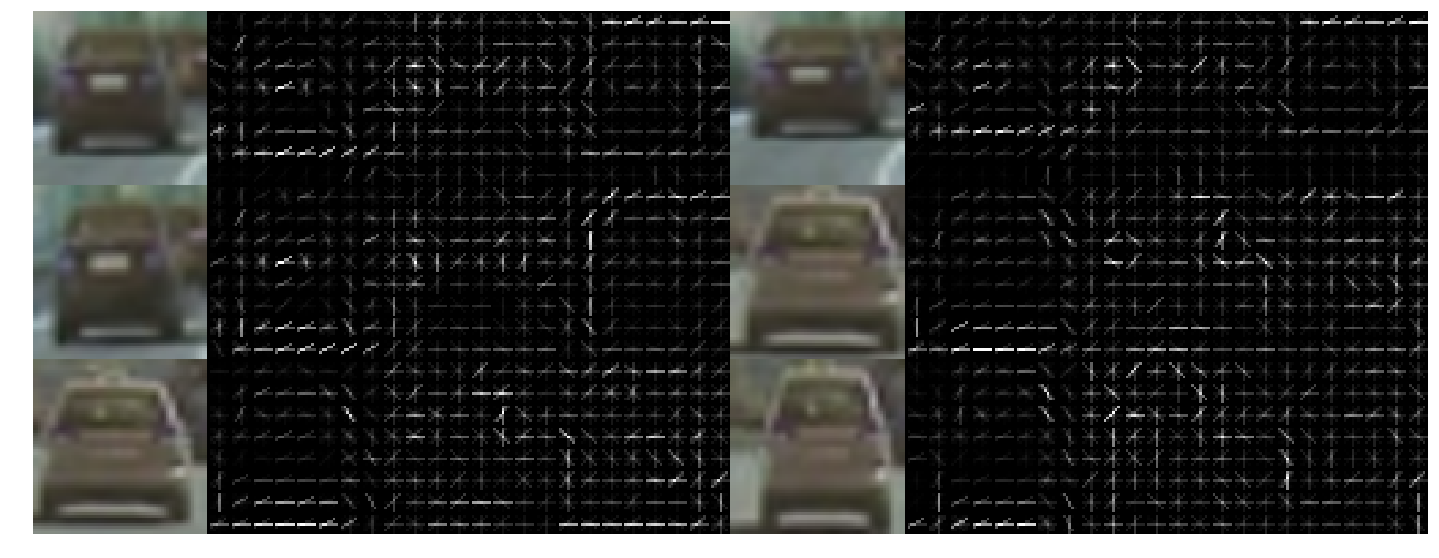

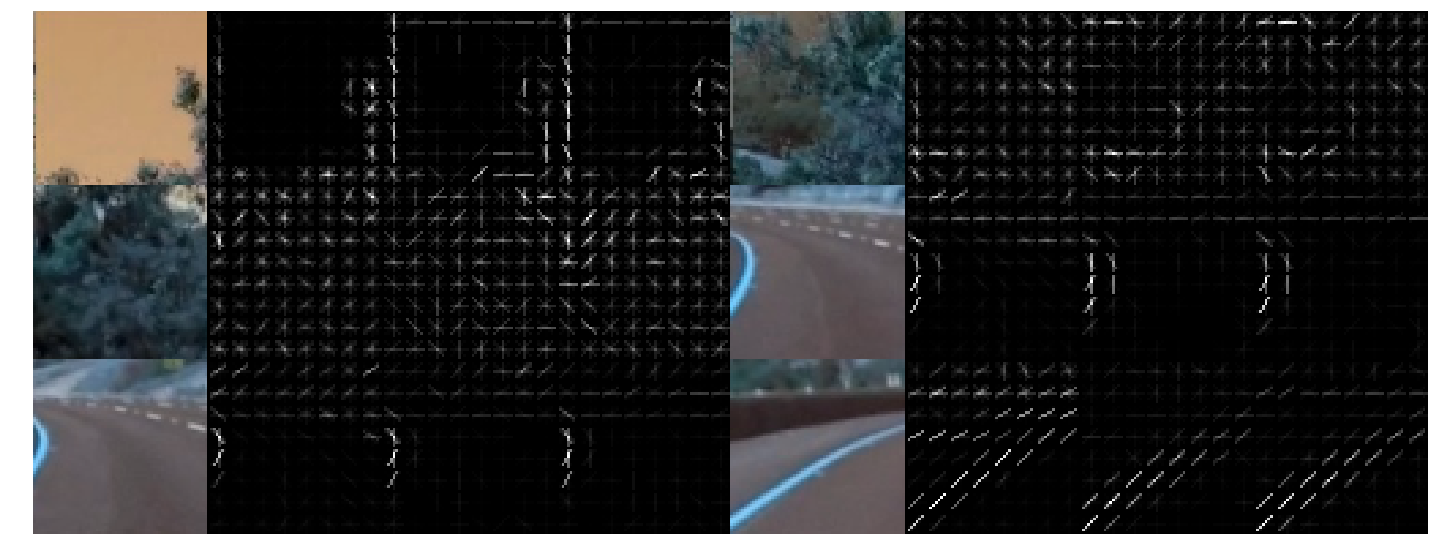

In [6]:
preview_cars = hog_previews(files_cars[:6])
display_image_set(preview_cars, "hog_cars", cols_num=8)

preview_noncars = hog_previews(files_noncars[:6])
display_image_set(preview_noncars, "hog_noncars", cols_num=8)

In [8]:
imgs = load_images(files_cars, num=100)

colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orientations = range(6, 13)
px_per_cells = range(6, 17)
cells_per_blocks = range(1, 4)
channels = [None, 0, 1, 2]

for space in colorspaces:
    for orientation in orientations:
        for px_per_cell in px_per_cells:
            for cells_per_block in cells_per_blocks:
                for channel in channels:
                    t = time.time()
                    hog_images(imgs, channel=channel, orient=orientation, pix_per_cell=px_per_cell, 
                                                   cell_per_block=cells_per_block, colorspace=space)
                    t2 = time.time()
                    print('Images: {} | Time: {}sec | Space {} | Orient {} | PPC {} | CPB {} | Channel {}'
                          .format(len(imgs), round(t2 - t, 2), space, orientation, px_per_cell, cells_per_block, channel))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Images: 100 | Time: 19.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel None
Images: 100 | Time: 6.96sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 0
Images: 100 | Time: 6.76sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 1
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 2
Images: 100 | Time: 20.54sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel None
Images: 100 | Time: 6.4sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 0
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 1
Images: 100 | Time: 6.35sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 2
Images: 100 | Time: 24.58sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel None
Images: 100 | Time: 8.66sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 0
Images: 100 | Time: 8.64sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 1
Images: 100 | Time: 11.19sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 2
Images: 100 | Time: 21.11sec | Space RGB

Images: 100 | Time: 2.06sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 1
Images: 100 | Time: 1.84sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 2
Images: 100 | Time: 5.61sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel None
Images: 100 | Time: 1.82sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 0
Images: 100 | Time: 1.85sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 1
Images: 100 | Time: 2.38sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 2
Images: 100 | Time: 6.22sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel None
Images: 100 | Time: 2.03sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 0
Images: 100 | Time: 2.39sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 1
Images: 100 | Time: 1.92sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 2
Images: 100 | Time: 6.42sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel None
Images: 100 | Time: 2.43sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel 0
Images: 100 | Time: 2.14sec | S

Images: 100 | Time: 5.74sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel None
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 0
Images: 100 | Time: 1.44sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 1
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 2
Images: 100 | Time: 4.34sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel None
Images: 100 | Time: 1.43sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 0
Images: 100 | Time: 1.51sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 1
Images: 100 | Time: 2.1sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 2
Images: 100 | Time: 4.1sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel None
Images: 100 | Time: 1.08sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 0
Images: 100 | Time: 0.89sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 1
Images: 100 | Time: 1.41sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 2
Images: 100 | Time: 2.79sec | Spa

KeyboardInterrupt: 

In [7]:
features_cars = features_from_files(files_cars)
print("Processed cars", len(features_cars))
features_noncars = features_from_files(files_noncars)
print("Processed noncars", len(features_noncars))

X = np.vstack((features_cars, features_noncars)).astype(np.float64)
y = np.append(np.ones(len(features_cars)), np.zeros(len(features_noncars)))
print("Stacked", X.shape, y.shape)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
print("Train features {}, labels {}".format(X_train.shape, y_train.shape))
print("Test features {}, labels {}".format(X_test.shape, y_test.shape))

Processed cars 8792
Processed noncars 8968
Stacked (17760, 5568) (17760,)
Train features (14208, 5568), labels (14208,)
Test features (3552, 5568), labels (3552,)


In [8]:
svc = LinearSVC(loss='hinge')
svc.fit(X_train, y_train)
print('Test Accuracy', round(svc.score(X_test, y_test), 4))

X = X_test[0:10]
y = y_test[0:10]
print('Prediction:', svc.predict(X))
print('True Label:', y)

Test Accuracy 0.9927
Prediction: [ 0.  1.  0.  0.  1.  1.  1.  0.  0.  0.]
True Label: [ 0.  1.  0.  0.  1.  1.  1.  0.  0.  0.]


In [195]:
class Vehicle():
    def __init__(self, svc, X_scaler):
        self.svc = svc
        self.X_scaler = X_scaler
        self.prev_rects = []
        self.max_rects = 15
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        slice_num = len(self.prev_rects) - self.max_rects
        self.prev_rects = self.prev_rects[slice_num:]
        
    def preview_windows(self, img, margin_y, win_size):
        windows = slide_windows(img, margin_y, win_size)
        result = draw_boxes(img, windows)
        
        return result[margin_y[0]:margin_y[1], 0:result.shape[1], :]
    
    def preview_search(self, img, margin_y, win_size):
        windows = slide_windows(img, margin_y, win_size)
        win_rects = search_windows(img, windows, self.svc, self.X_scaler)
        result = draw_boxes(img, win_rects)
        
        return result[margin_y[0]:margin_y[1], 0:result.shape[1], :]
    
    def preview_multiple_search(self, img, margin_y):
        win_sizes = [32, 64, 96, 128]
        rects = []
        
        for win_size in win_sizes:
            windows = slide_windows(img, margin_y, win_size)
            win_rects = search_windows(img, windows, self.svc, self.X_scaler)
            rects.extend(win_rects)

        img = draw_boxes(img, rects)
        return img[margin_y[0]:margin_y[1], 0:result.shape[1], :]
    
    def preview_heat(self, img, margin_y):
        win_sizes = [32, 64, 96, 128]
        rects = []

        for win_size in win_sizes:
            windows = slide_windows(img, margin_y, win_size)
            win_rects = search_windows(img, windows, self.svc, self.X_scaler)
            rects.extend(win_rects)

        min_boxes = 3
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, rects, 3)
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_HOT)

        return heat[margin_y[0]:margin_y[1], 0:result.shape[1]]
        
    def process_frame(self, img):
#         windows = slide_windows(img)
#         rects = search_windows(img, windows, self.svc, self.X_scaler)
#         self.add_rects(rects)

        return draw_boxes(img, windows)

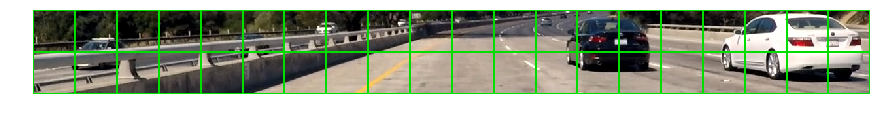

In [148]:
win_size = 64
rows = 2
start_y = 400
margin_y = (start_y, start_y + win_size * rows)

img = cv2.imread('./test_images/test1.jpg')
vehicle = Vehicle(svc, X_scaler)
result = vehicle.preview_windows(img, margin_y, win_size)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.axis('off')
plt.show()

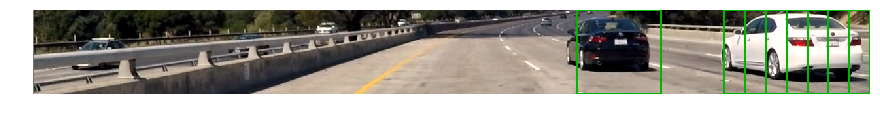

In [154]:
win_size = 128
rows = 1
start_y = 400
margin_y = (start_y, start_y + win_size * rows)

img = cv2.imread('./test_images/test1.jpg')
vehicle = Vehicle(svc, X_scaler)
result = vehicle.preview_search(img, margin_y, win_size)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.axis('off')
plt.show()

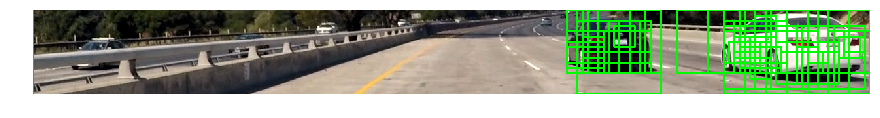

In [155]:
win_size = 128
rows = 1
start_y = 400
margin_y = (start_y, start_y + win_size * rows)

img = cv2.imread('./test_images/test1.jpg')
vehicle = Vehicle(svc, X_scaler)
result = vehicle.preview_multiple_search(img, margin_y)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.axis('off')
plt.show()

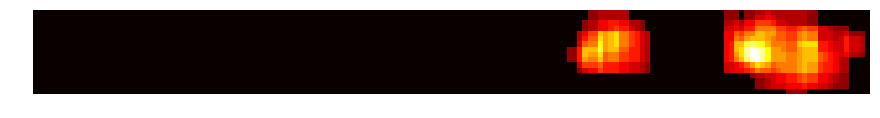

In [197]:
win_size = 128
rows = 1
start_y = 400
margin_y = (start_y, start_y + win_size * rows)

img = cv2.imread('./test_images/test1.jpg')
vehicle = Vehicle(svc, X_scaler)
result = vehicle.preview_heat(img, margin_y)
    
plt.figure(figsize=(15,15))
plt.imshow(result, cmap='hot')
plt.axis('off')
plt.show()

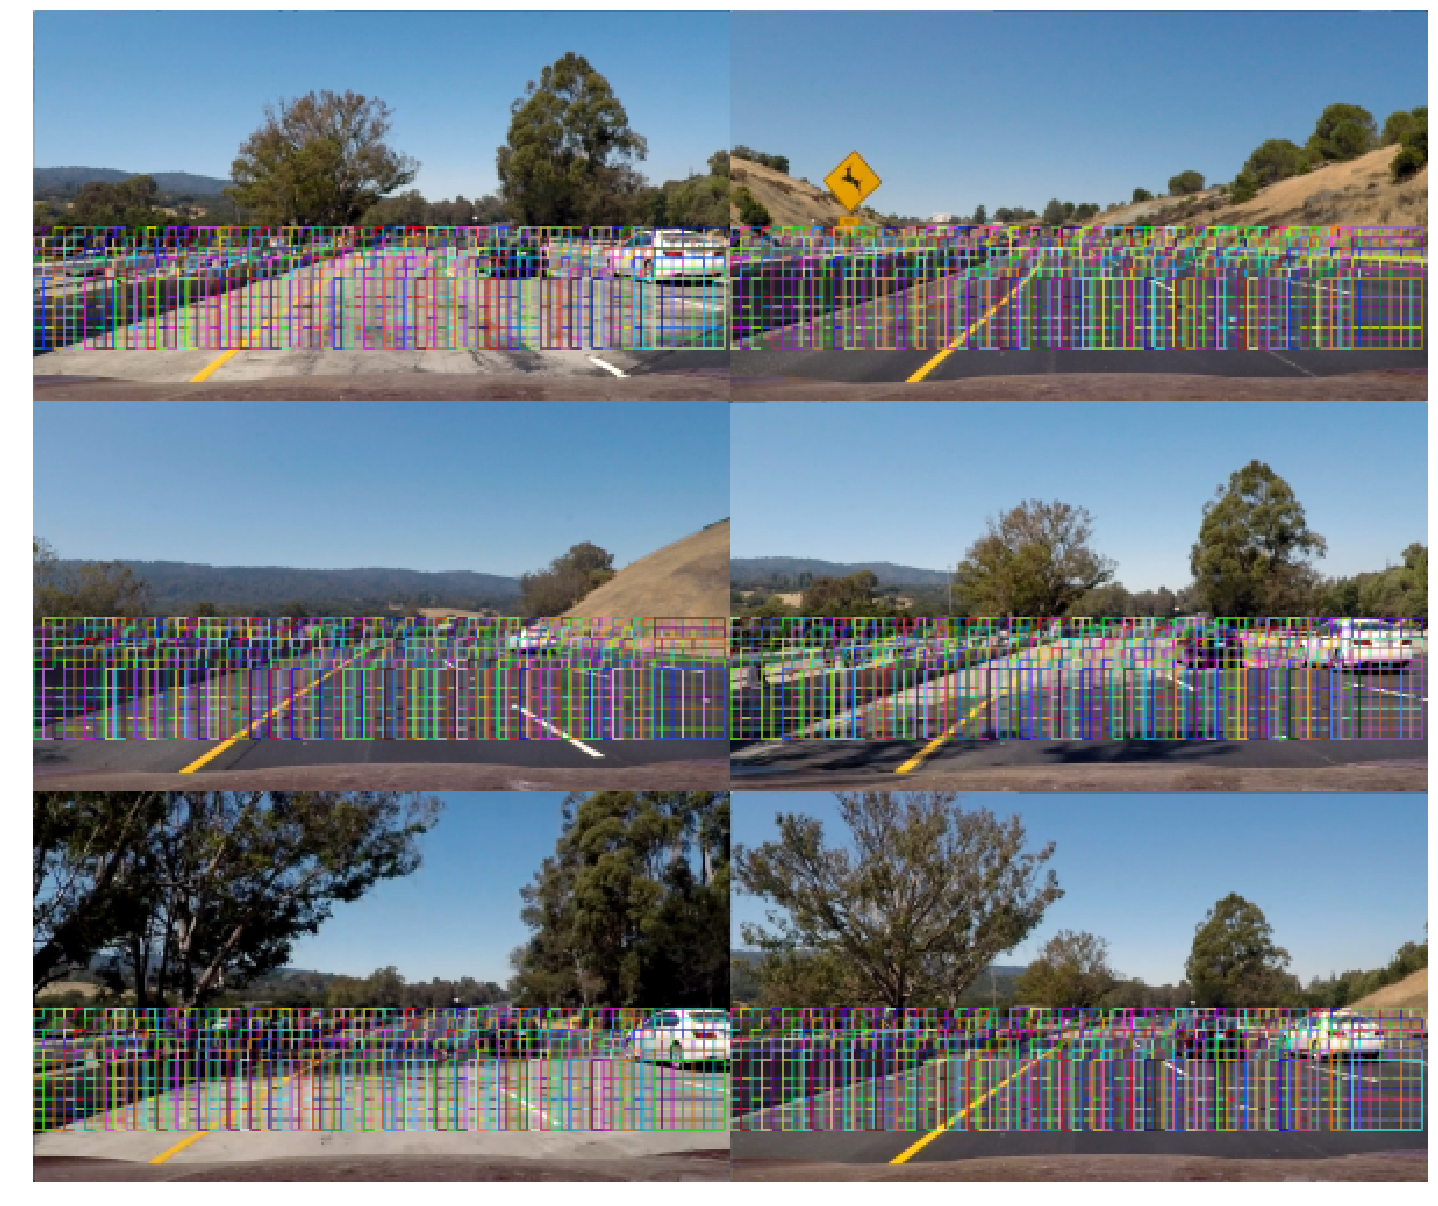

In [28]:
test_files = glob.glob('./test_images/test*.jpg')
results = []
vehicle = Vehicle()

for idx, file in enumerate(test_files):
    img = cv2.imread(file)
    draw_img = vehicle.process_frame(img)
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    results.append(draw_img)
    
display_image_set(results, "result_preview", cols_num=2, width=600)

In [48]:
vehicle = Vehicle()
source = './source_videos/test_video.mp4'
out = './output_videos/test_video.mp4'
clip = VideoFileClip(source).subclip(0,1)
clip_out = clip.fl_image(vehicle.process_frame)
%time clip_out.write_videofile(out, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 96%|█████████▌| 25/26 [01:16<00:03,  3.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

CPU times: user 1min 14s, sys: 926 ms, total: 1min 15s
Wall time: 1min 18s


In [35]:
vehicle = Vehicle()
source = './source_videos/project_video.mp4'
out = './output_videos/project_video.mp4'
clip_proj = VideoFileClip()
clip_proj_out = clip_test2.fl_image(vehicle.process_frame)
%time clip_proj_out.write_videofile(source, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_out.mp4
[MoviePy] Writing video ./output_videos/project_video_out.mp4


 97%|█████████▋| 38/39 [03:07<00:05,  5.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_out.mp4 

CPU times: user 3min 4s, sys: 2.29 s, total: 3min 6s
Wall time: 3min 10s
